## Imports and definitions

In [1]:
import ot
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
import time
from tqdm import tqdm

In [2]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)

In [3]:
resolutions = [32, 64, 128, 256, 512]
image_numbers = ['01','02','03','04','05','06','07','08','09','10']

In [4]:
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]
for category in category_names:
    print(category)

CauchyDensity
ClassicImages
GRFmoderate
GRFrough
GRFsmooth
LogGRF
LogitGRF
MicroscopyImages
Shapes
WhiteNoise


# Reading images

## Single Image

In [322]:
image_1_index = 2
image_2_index = 3
resolution = 32
noise_param = 3e-6
SNR = 1

In [323]:
len(category_names)
category_names[0]

'CauchyDensity'

In [324]:
len(image_numbers)


10

In [325]:
image1 = Image(resolution, category_names[0], image_1_index, full_path)
image2 = Image(resolution, category_names[0], image_2_index, full_path)
cost_matrix = calculate_costs(image1.image.shape)


In [326]:
results = Image.analyze_image_pair(image1, image2, cost_matrix, 1, noise_param)

In [327]:
print(f'The mass of image1 noised before norm is {image1.image_noised.sum()}')
print(f'The mass of image1 post before norm is {image1.image_post_noised.sum()}')
print(f'The mass of image2 noised before norm is {image2.image_noised.sum()}')
print(f'The mass of image2 post before norm is {image2.image_post_noised.sum()}')

The mass of image1 noised before norm is 1.0001686668246121
The mass of image1 post before norm is 1.0002048338023564
The mass of image2 noised before norm is 0.9999680195459026
The mass of image2 post before norm is 1.0000041865236469


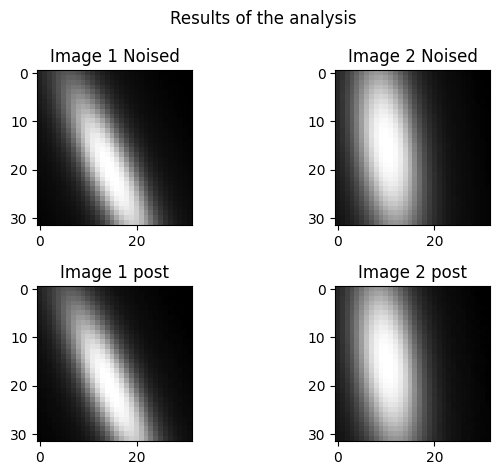

In [328]:
# Plot using 4 plots
fig, axs = plt.subplots(2, 2)
fig.suptitle('Results of the analysis')
axs[0, 0].imshow(image1.image_noised, cmap='gray')
axs[0, 0].set_title('Image 1 Noised')
axs[0, 1].imshow(image2.image_noised, cmap='gray')
axs[0, 1].set_title('Image 2 Noised')
axs[1, 0].imshow(image1.image_post_noised, cmap='gray')
axs[1, 0].set_title('Image 1 post')
axs[1, 1].imshow(image2.image_post_noised, cmap='gray')
axs[1, 1].set_title('Image 2 post')

plt.tight_layout()
plt.show()

In [329]:
alpha_1 = (1 / image1.image_post_noised.sum()) - 1
alpha_2 = (1 / image2.image_post_noised.sum()) - 1

In [330]:
num_exp = 2000
B_x_matrices = np.zeros((num_exp, resolution, resolution))
alpha_1s = np.zeros(num_exp)
alpha_2s = np.zeros(num_exp)
image1 = Image(resolution, category_names[0], image_1_index, full_path)
image2 = Image(resolution, category_names[0], image_2_index, full_path)

for i in tqdm(range(num_exp)):
    results = Image.process_images(image1, image2, noise_param)

    alpha_1 = (1 / image1.image_post_noised.sum()) - 1
    alpha_2 = (1 / image2.image_post_noised.sum()) - 1

    B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2

    alpha_1s[i] = alpha_1
    alpha_2s[i] = alpha_2
    B_x_matrices[i, :, :] = B_x

B_x_mean = np.mean(B_x_matrices, axis=0)
B_x_std = np.std(B_x_matrices, axis=0)

100%|██████████| 2000/2000 [00:00<00:00, 14073.59it/s]


In [331]:
B_x_mean.shape

(32, 32)

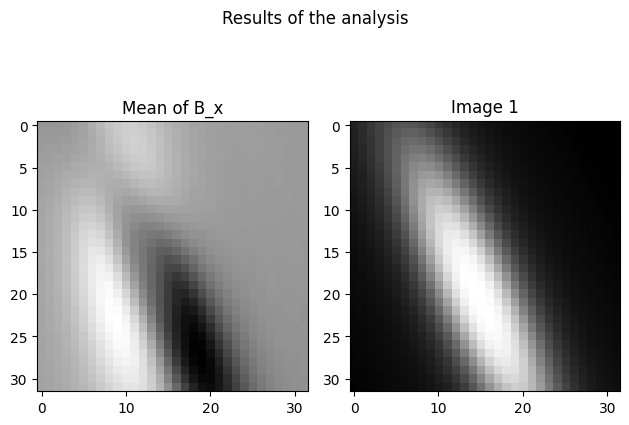

In [332]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Results of the analysis')
axs[0].imshow(B_x_mean, cmap='gray')
axs[0].set_title('Mean of B_x')
axs[1].imshow(image1.image, cmap='gray')
axs[1].set_title('Image 1')
plt.tight_layout()
plt.show()

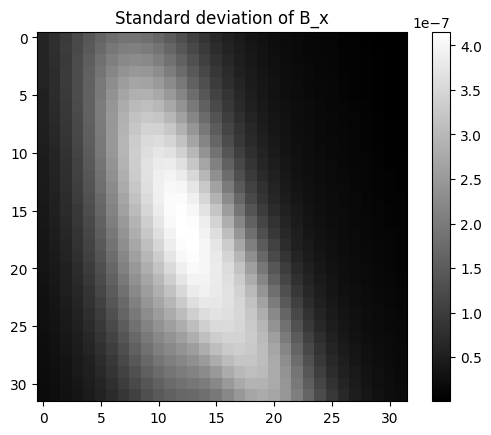

In [333]:
# Plot the standard deviation
plt.imshow(B_x_std, cmap='gray')
plt.title('Standard deviation of B_x')
# Show the values of the standard deviation using a colorbar
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Alpha 2')

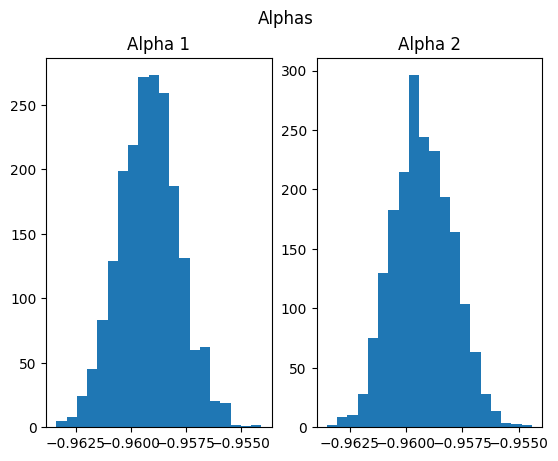

In [96]:
# Plot the alphas
fig, axs = plt.subplots(1, 2)
fig.suptitle('Alphas')
axs[0].hist(alpha_1s, bins=20)
axs[0].set_title('Alpha 1')
axs[1].hist(alpha_2s, bins=20)
axs[1].set_title('Alpha 2')

In [97]:
# Calculate the mean and std of the alphas
alpha_1_mean = alpha_1s.mean()
alpha_2_mean = alpha_2s.mean()
alpha_1_std = alpha_1s.std()
alpha_2_std = alpha_2s.std()
sum_image1_post = 1 / (1 + alpha_1_mean)
sum_image2_post = 1 / (1 + alpha_2_mean)

print(f'The mean of alpha 1 is {alpha_1_mean} and the std is {alpha_1_std}, the sum of image 1 post is {sum_image1_post}')
print(f'The mean of alpha 2 is {alpha_2_mean} and the std is {alpha_2_std}, the sum of image 2 post is {sum_image2_post}')

The mean of alpha 1 is -0.9591626814802503 and the std is 0.0013541184103240816, the sum of image 1 post is 24.487406035643136
The mean of alpha 2 is -0.9592617988785912 and the std is 0.0013233230151688993, the sum of image 2 post is 24.54698470901501


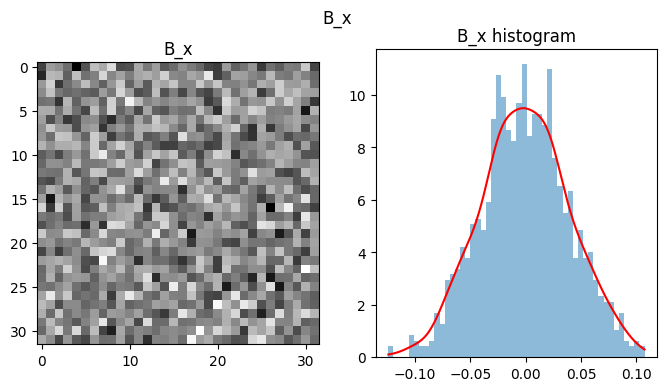

In [98]:
from scipy.stats import norm, gaussian_kde
# Show B_x and it's histogram:
figsize = (8, 4)
fig, axs = plt.subplots(1, 2, figsize=figsize)
fig.suptitle('B_x')
axs[0].imshow(B_x, cmap='gray')
axs[0].set_title('B_x')

axs[1].hist(B_x.flatten(), bins=50, density=True, alpha=0.5, label='Histogram')
kde = gaussian_kde(B_x.flatten(), bw_method='silverman')
x = np.linspace(B_x.min(), B_x.max(), 1000)
kde_pdf = kde(x)
axs[1].plot(x, kde_pdf, label='KDE', color='red')
axs[1].set_title('B_x histogram')

plt.show()

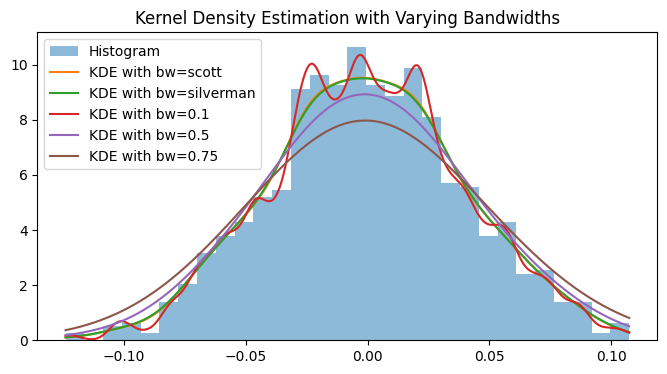

In [99]:
def plot_kde(data, bandwidths):
    fig, ax = plt.subplots(figsize=(8, 4))
    # Histogram
    ax.hist(data, bins=30, density=True, alpha=0.5, label='Histogram')

    # Generate x values for plotting
    x = np.linspace(min(data), max(data), 1000)

    # Plot KDE for each specified bandwidth
    for bw in bandwidths:
        kde = gaussian_kde(data, bw_method=bw)
        kde_pdf = kde(x)
        ax.plot(x, kde_pdf, label=f'KDE with bw={bw}')
    
    ax.set_title('Kernel Density Estimation with Varying Bandwidths')
    ax.legend()
    plt.show()

# List of bandwidths to try
bandwidths = ['scott', 'silverman', 0.1, 0.5, 0.75]

# Plotting the KDE with different bandwidths
plot_kde(B_x.flatten(), bandwidths)

In [100]:
print(f'For noise level {noise_param}, The mean of B_x is {B_x.mean()} and the std is {B_x.std()}')

For noise level 0.03, The mean of B_x is -0.0004047035262012261 and the std is 0.03986854106115369


### Several noise values

In [207]:
noise_values = np.logspace(start = -8, stop = 2, num = 100)
# noise_values = np.logspace(start = -3, stop = -1, num = 6)

In [208]:
image_indexes = np.random.randint(1, 10, 2)
image_indexes[1]

4

In [222]:
num_exp = 1000
alpha_1s = np.zeros(num_exp)
alpha_2s = np.zeros(num_exp)
B_x_means = np.zeros(len(noise_values))
B_x_stds = np.zeros(len(noise_values))
alpha_means = np.zeros(len(noise_values))
alpha_stds = np.zeros(len(noise_values))

for noise in tqdm(noise_values):
    noise_location = np.where(noise_values == noise)
    temp_stds = []
    temp_means = []
    temp_alpha = []
    for i in range(num_exp):
        image_indexes = np.random.randint(0, 10, 2)
        category_indexes = np.random.randint(0, 10, 2)
        image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
        image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)
        #image1 = Image(resolution, category_names[0], image_1_index, full_path)
        #image2 = Image(resolution, category_names[0], image_2_index, full_path)
        results = Image.process_images(image1, image2, noise)

        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2

        alpha_1s[i] = alpha_1
        alpha_2s[i] = alpha_2

        temp_means.append(B_x.mean())
        temp_stds.append(B_x.std()) 
        temp_alpha.append(alpha_1)

    B_x_means[noise_location] = np.array(temp_means).mean()
    B_x_stds[noise_location] = np.array(temp_stds).mean()
    alpha_means[noise_location] = np.array(temp_alpha).mean()
    alpha_stds[noise_location] = np.array(temp_alpha).std()

100%|██████████| 100/100 [08:06<00:00,  4.87s/it]


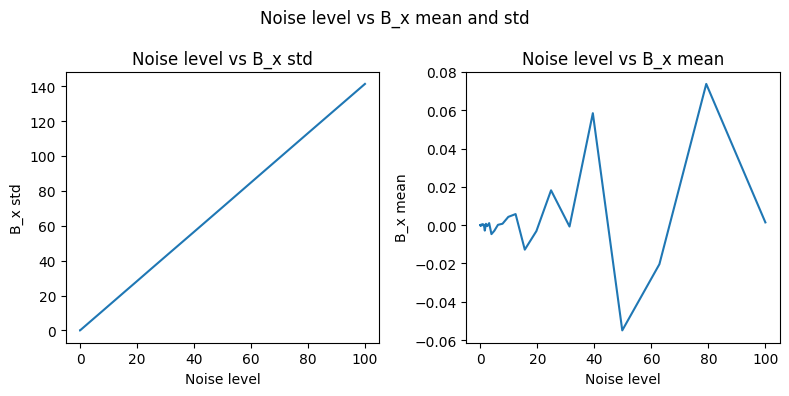

In [223]:
# Plot The noise vs the std of B_x and the mean on the other side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Noise level vs B_x mean and std')
axs[0].plot(noise_values, B_x_stds)
axs[0].set_xlabel('Noise level')
# axs[0].set_xscale('log')
axs[0].set_ylabel('B_x std')
axs[0].set_title('Noise level vs B_x std')
axs[1].plot(noise_values, B_x_means)
axs[1].set_xlabel('Noise level')
axs[1].set_xscale('log')
axs[1].set_ylabel('B_x mean')
axs[1].set_title('Noise level vs B_x mean')

plt.tight_layout()
plt.show()

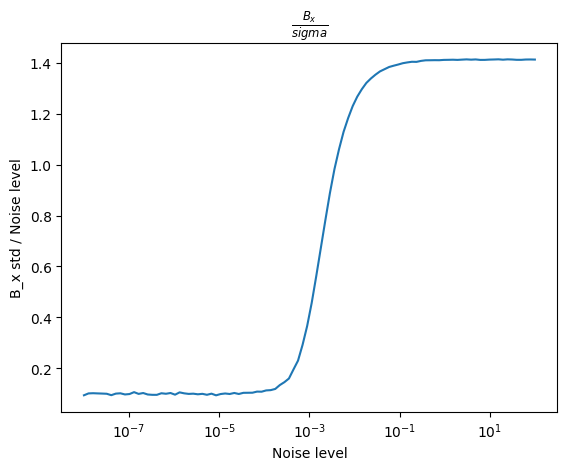

In [301]:
plt.plot(noise_values, B_x_stds / noise_values)
plt.xlabel('Noise level')
plt.xscale('log')
plt.ylabel('B_x std / Noise level')
plt.title(r"$\frac{B_x}{sigma}$")
plt.show()

The mean of alpha 1 is -0.9999876216015415 and the std is 2.377158251548875e-07


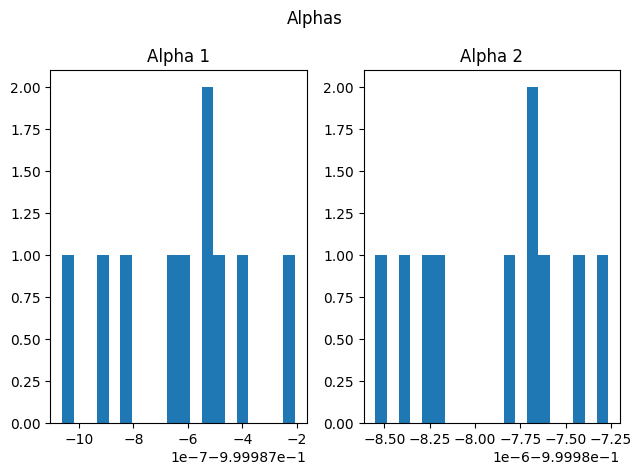

In [297]:
#plot the alphas
fig, axs = plt.subplots(1, 2)
# Print the means:
print(f'The mean of alpha 1 is {alpha_1s.mean()} and the std is {alpha_1s.std()}')
print(f'The mean of alpha 2 is {alpha_2s.mean()} and the std is {alpha_2s.std()}')
fig.suptitle('Alphas')
axs[0].hist(alpha_1s, bins=20)
axs[0].set_title('Alpha 1')
axs[1].hist(alpha_2s, bins=20)
axs[1].set_title('Alpha 2')

plt.tight_layout()
plt.show()

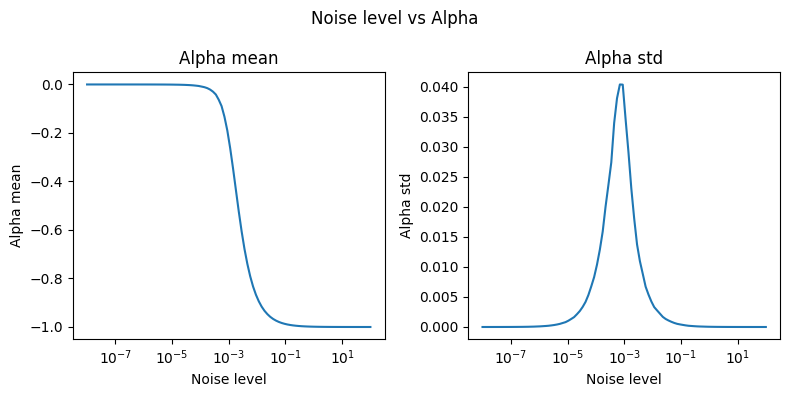

In [237]:
# plot alpha as a function of noise
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Noise level vs Alpha')
axs[0].plot(noise_values, alpha_means)
axs[0].set_xlabel('Noise level')
axs[0].set_xscale('log')
axs[0].set_ylabel('Alpha mean')
axs[0].set_title('Alpha mean')
axs[1].plot(noise_values, alpha_stds)
axs[1].set_xlabel('Noise level')
axs[1].set_xscale('log')
axs[1].set_ylabel('Alpha std')
axs[1].set_title('Alpha std')

plt.tight_layout()
plt.show()

#### Check if $B_x$ stays in the neighborhood of zero for all images and classes

In [290]:
num_exp = 10
results_B_x = pd.DataFrame(columns=[
    'Category', 'Image_Pair', 'Alpha_1_Mean', 'Alpha_1_Std', 'Alpha_2_Mean', 'Alpha_2_Std', 'B_x_Mean', 'B_x_Std'])


for category in category_names:
    print(f'Category: {category}')
    for noise in noise_values:
        for pair in list(itertools.combinations(image_numbers, 2)):
            alpha_1s = np.zeros(num_exp)
            alpha_2s = np.zeros(num_exp)
            B_xs = np.zeros((num_exp, resolution, resolution))  # Store B_x for each experiment
            image1 = Image(resolution, category_names[0], pair[0], full_path)
            image2 = Image(resolution, category_names[0], pair[1], full_path)

            for i in range(num_exp):
                results = Image.process_images(image1, image2, noise)
                alpha_1 = (1 / image1.image_post_noised.sum()) - 1
                alpha_2 = (1 / image2.image_post_noised.sum()) - 1
                B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2
                alpha_1s[i] = alpha_1
                alpha_2s[i] = alpha_2
                B_xs[i, :, :] = B_x  # Store each B_x result

            # Calculate the means and standard deviations
            alpha_1_mean, alpha_1_std = alpha_1s.mean(), alpha_1s.std()
            alpha_2_mean, alpha_2_std = alpha_2s.mean(), alpha_2s.std()
            B_x_mean, B_x_std = B_xs.mean(axis=0), B_xs.std(axis=0)

            # Flatten B_x_mean and B_x_std for storage in DataFrame
            B_x_mean_flat = B_x_mean.flatten()
            B_x_std_flat = B_x_std.flatten()

            # Store results in the DataFrame
            results_B_x = results_B_x._append({
                'Category': category,
                'Noise': noise,
                'Image_Pair': pair,
                'Alpha_1_Mean': alpha_1_mean,
                'Alpha_1_Std': alpha_1_std,
                'Alpha_2_Mean': alpha_2_mean,
                'Alpha_2_Std': alpha_2_std,
                'B_x_Mean': B_x_mean_flat.mean(),  # Storing the overall mean of the matrix
                'B_x_Std': B_x_std_flat.mean()    # Storing the overall mean of the std of the matrix
            }, ignore_index=True)

Category: CauchyDensity


C:\Users\eriki\AppData\Local\Temp\ipykernel_21788\1535454990.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_B_x = results_B_x._append({


Category: ClassicImages
Category: GRFmoderate
Category: GRFrough
Category: GRFsmooth
Category: LogGRF
Category: LogitGRF
Category: MicroscopyImages
Category: Shapes
Category: WhiteNoise


In [292]:
results_B_x.head()

,Category,Image_Pair,Alpha_1_Mean,Alpha_1_Std,Alpha_2_Mean,Alpha_2_Std,B_x_Mean,B_x_Std,Noise
0,CauchyDensity,"(01, 02)",-0.000002,2.255500e-07,-0.000002,3.285735e-07,2.135859e-10,4.782955e-10,1.000000e-08
1,CauchyDensity,"(01, 03)",-0.000002,2.860001e-07,-0.000002,2.385021e-07,1.946755e-10,3.796071e-10,1.000000e-08
2,CauchyDensity,"(01, 04)",-0.000002,3.633786e-07,-0.000002,3.342135e-07,-1.157064e-10,4.831623e-10,1.000000e-08
3,CauchyDensity,"(01, 05)",-0.000002,3.337681e-07,-0.000002,3.759075e-07,-2.717828e-11,6.624325e-10,1.000000e-08
4,CauchyDensity,"(01, 06)",-0.000002,1.749493e-07,-0.000001,2.374813e-07,-1.945453e-10,3.691906e-10,1.000000e-08


In [293]:
results_B_x = results_B_x.drop(['Category', 'Image_Pair'], axis=1)

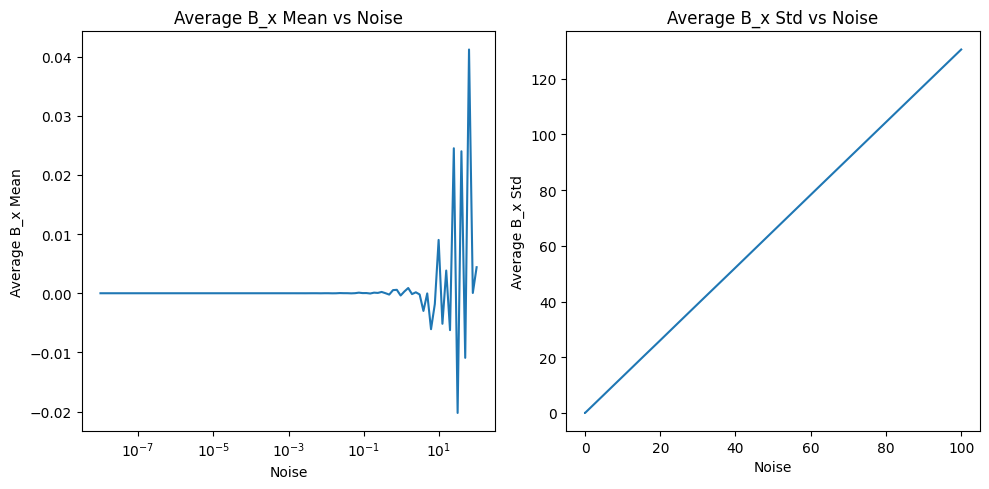

In [303]:
grouped_results = results_B_x.groupby('Noise').mean().reset_index()

# Plot B_x_mean vs Noise
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(grouped_results['Noise'], grouped_results['B_x_Mean'])
plt.xscale('log')
plt.xlabel('Noise')
plt.ylabel('Average B_x')
plt.title('Average B_x in every pixel')

# Plot B_x_std vs Noise
plt.subplot(1, 2, 2)
plt.plot(grouped_results['Noise'], grouped_results['B_x_Std'])
# plt.xscale('log')
plt.xlabel('Noise')
plt.ylabel('Average B_x Std')
plt.title('Average B_x Std vs Noise')

plt.tight_layout()
plt.show()

### Looking into the total sum, $[\sum_{x\in G_N} e^{-i<x,k>} \cdot B_x] \times [\sum_{y\in G_N} e^{i<y,k>} \cdot B_y]$

In [304]:
num_exp = 100
noise_values = np.logspace(start = -8, stop = 2, num = 100)
summands_lists = [] * len(noise_values)
summands_means = np.zeros(len(noise_values))

for noise in tqdm(noise_values):
    summands = []
    noise_location = np.where(noise_values == noise)
    for i in range(num_exp):
        image_indexes = np.random.randint(0, 10, 2)
        category_indexes = np.random.randint(0, 10, 2)
        image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
        image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)
        sum = 0
        sum_left = 0
        sum_right = 0
        results = Image.process_images(image1, image2, noise_param)
        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1
        k = np.random.randint(1, resolution + 1, size=2)
        # This is for the left summand in (44) - sum of exp{-i<x,k>} B_x
        for x in range(resolution):
            for y in range(resolution):
                B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                location = np.array([x, y])
                exponent = np.exp(-1j * np.dot(location, k))
                summand = exponent * B_x
                sum_left += summand
        # This is for the right summand in (44) - sum of exp{i<y,k>} B_y
        for x in range(resolution):
            for y in range(resolution):
                B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                location = np.array([x, y])
                exponent = np.exp(1j * np.dot(location, k))
                summand = exponent * B_x
                sum_right += summand
        sum = abs(sum_left * sum_right)
        summands.append(sum)
        
    summands_lists.append(summands)
    summands_means[noise_location] = np.mean(summands)

 43%|████▎     | 43/100 [00:39<00:52,  1.08it/s]


KeyboardInterrupt: 

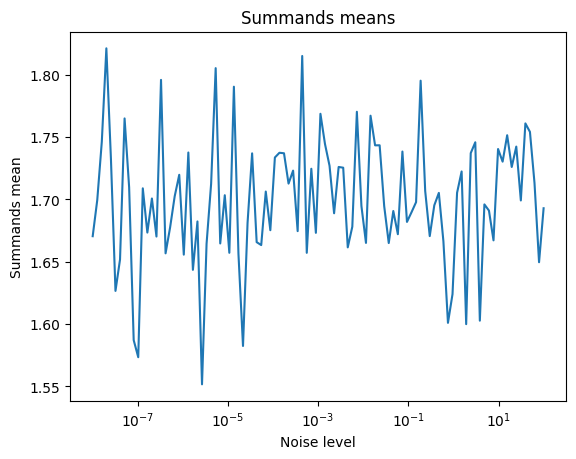

In [ ]:
plt.plot(noise_values, summands_means)
# plt.axhline(y=np.mean(summands_means), color='r', linestyle='-', label='Mean')
plt.xlabel('Noise level')
plt.xscale('log')
plt.ylabel('Summands mean')
plt.title('Summands means')
plt.show()

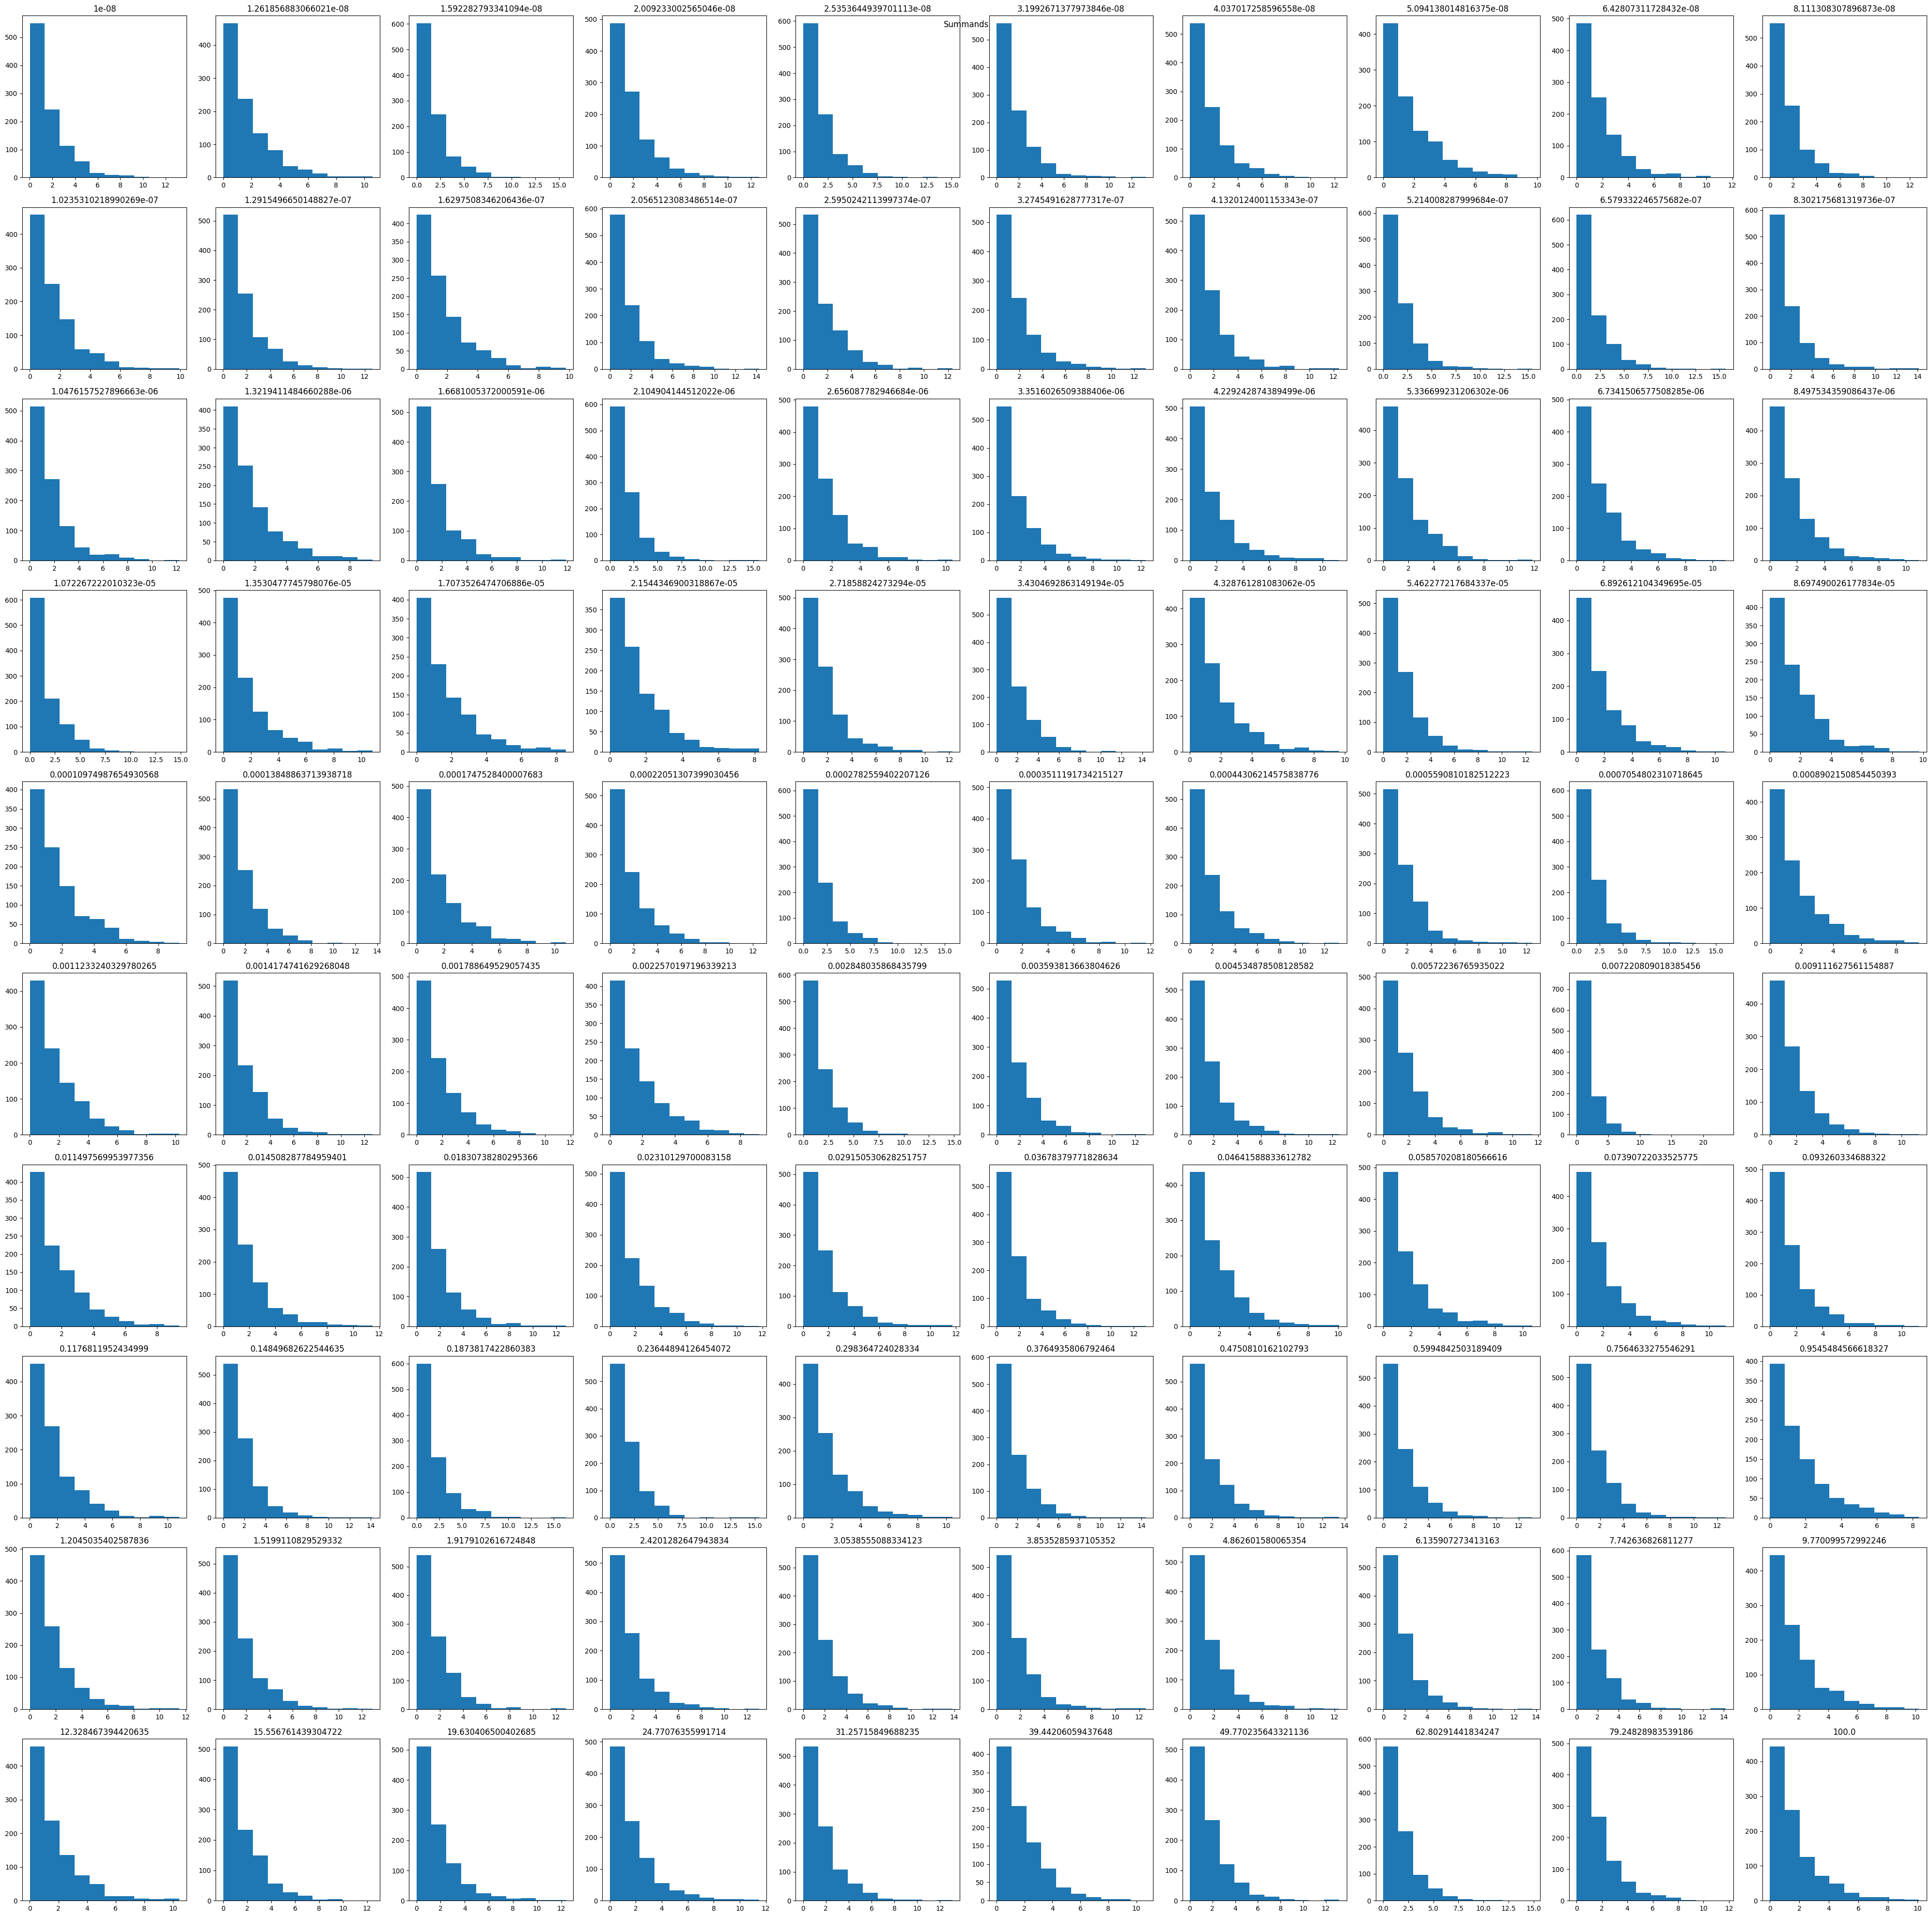

In [269]:
# plot a 10x10 grid of the summands
fig, axs = plt.subplots(10, 10, figsize=(40, 40))
fig.suptitle('Summands')
for i in range(10):
    for j in range(10):
        axs[i, j].hist(summands_lists[i * 10 + j])
        axs[i, j].set_title(f'{noise_values[i * 10 + j]}')
plt.tight_layout()
plt.show()

### different classes, structured

In [305]:
num_exp = 10
noise_values = np.logspace(start = -8, stop = 2, num = 100)
# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['Noise', 'Category', 'Image_Pair', 'Experiment', 'Sum_Left', 'Sum_Right', 'Abs_Sum'])

for noise in tqdm(noise_values):
    for category in category_names:
        for pair in list(itertools.combinations(image_numbers, 2)):
            image1 = Image(resolution, category, pair[0], full_path)
            image2 = Image(resolution, category, pair[1], full_path)
            for i in range(num_exp):
                sum = 0
                sum_left = 0
                sum_right = 0
                results = Image.process_images(image1, image2, noise)
                alpha_1 = (1 / image1.image_post_noised.sum()) - 1
                alpha_2 = (1 / image2.image_post_noised.sum()) - 1
                k = np.random.randint(1, resolution + 1, size=2)
                # This is for the left summand in (44) - sum of exp{-i<x,k>} B_x
                for x in range(resolution):
                    for y in range(resolution):
                        B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                        location = np.array([x, y])
                        exponent = np.exp(-1j * np.dot(location, k))
                        summand = exponent * B_x
                        sum_left += summand
                # This is for the right summand in (44) - sum of exp{i<x,k>} B_x
                for x in range(resolution):
                    for y in range(resolution):
                        B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                        location = np.array([x, y])
                        exponent = np.exp(1j * np.dot(location, k))
                        summand = exponent * B_x
                        sum_right += summand
                sum = abs(sum_left * sum_right)
                result = {
                    'Noise': noise,
                    'Category': category,
                    'Image_Pair': pair,
                    'Experiment': i + 1,  # experiment number (1 indexed)
                    'Sum_Left': sum_left,
                    'Sum_Right': sum_right,
                    'Abs_Sum': sum
                }

                # Append the result to the DataFrame
                results_df = results_df._append(result, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_21788\3197954809.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append(result, ignore_index=True)
 40%|████      | 40/100 [33:06<49:40, 49.67s/it]  


KeyboardInterrupt: 

In [ ]:
results_df.head()

In [ ]:
results_df = results_df.drop(['Category', 'Image_Pair', 'Experiment'], axis=1)

In [ ]:
grouped_stats = results_df.groupby('Noise').agg({
    'Sum_Left': ['mean', 'std'],
    'Sum_Right': ['mean', 'std'],
    'Abs_Sum': ['mean', 'std']
}).reset_index()

grouped_stats.columns = ['Noise', 'Sum_Left_Mean', 'Sum_Left_Std', 'Sum_Right_Mean', 'Sum_Right_Std', 'Abs_Sum_Mean', 'Abs_Sum_Std']

In [ ]:
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Sum_Left
axs[0].errorbar(grouped_stats['Noise'], grouped_stats['Sum_Left_Mean'], yerr=grouped_stats['Sum_Left_Std'], fmt='-o')
axs[0].set_xscale('log')
axs[0].set_title('Mean and Std Dev of Sum_Left vs. Noise')
axs[0].set_xlabel('Noise')
axs[0].set_ylabel('Sum_Left')

# Sum_Right
axs[1].errorbar(grouped_stats['Noise'], grouped_stats['Sum_Right_Mean'], yerr=grouped_stats['Sum_Right_Std'], fmt='-o')
axs[1].set_xscale('log')
axs[1].set_title('Mean and Std Dev of Sum_Right vs. Noise')
axs[1].set_xlabel('Noise')
axs[1].set_ylabel('Sum_Right')

# Abs_Sum
axs[2].errorbar(grouped_stats['Noise'], grouped_stats['Abs_Sum_Mean'], yerr=grouped_stats['Abs_Sum_Std'], fmt='-o')
axs[2].set_xscale('log')
axs[2].set_title('Mean and Std Dev of Abs_Sum vs. Noise')
axs[2].set_xlabel('Noise')
axs[2].set_ylabel('Abs_Sum')

plt.tight_layout()
plt.show()